In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import accuracy_score
from sklearn import preprocessing, model_selection

In [5]:
from sklearn.datasets import load_wine
lb = preprocessing.LabelBinarizer()
lb.fit([0, 1, 2])
features, target = load_wine(return_X_y=True)

scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))

features = scaler.fit_transform(features)

X_train, X_test, y_labels_train, y_labels_test = model_selection.train_test_split(features, target, test_size=0.2, random_state=42)
y_train = lb.transform(y_labels_train)
y_test = lb.transform(y_labels_test)

[[ 0.74210526 -0.6284585   0.43315508 ..., -0.85365854 -0.49450549
  -0.45506419]
 [-0.21052632  0.88537549  0.36898396 ..., -0.44715447 -0.69230769
  -0.66191155]
 [-0.29473684 -0.86956522 -0.20855615 ..., -0.08943089  0.0989011
  -0.45506419]
 ..., 
 [ 0.76315789 -0.55335968  0.09090909 ...,  0.17073171  0.26739927
   0.81027104]
 [-0.12631579 -0.68774704 -0.03743316 ..., -0.2195122  -0.42124542
  -0.69044223]
 [-0.31052632 -0.32411067  0.17647059 ..., -0.4796748   0.54578755
  -0.77175464]]


In [6]:
class TriangMF:
    def __init__(self, a, b, c):
        self.a = a
        self.b = b
        self.c = c
        
    def __str__(self):
        return '[{0}, {1}, {2}]'.format(self.a, self.b, self.c)
    
    def __repr__(self):
        return str(self)
    
    def get_coord(self):
        return np.array([self.a, self.b, self.c])

    def calc_mf(self, x):        
        if self.a < x and x <= self.b:
            return (x - self.a) / (self.b - self.a)
        elif self.b < x and x <= self.c:
            return (self.c - x) / (self.c - self.b)
        else:
            return 0

In [7]:
class NeoFuzzyNode:
    train_algs_dict = {'KWH': 'train_KaczmarzWidrowHoff', 'alg': 'train_alg'}
    
    def __init__(self, n, m, h, train_alg='KWH'):
        self.n = n
        self.m = m
        self.h = h
        self.mf_list = self.init_mf(h, n)
        self.weights = np.random.normal(scale=0.1, size=(m, h * n))
        self.train_fun = getattr(self, self.train_algs_dict[train_alg])
    
    def init_mf(self, h, n):
        centers = np.linspace(-1, 1, h)
        width = centers[1] - centers[0]
        centers = np.concatenate([[centers[0]-width], centers, [centers[-1]+width]])        
        mf_list = []
        for i in range(1, h+1):
            mf_list.append(TriangMF(centers[i-1], centers[i], centers[i+1]))
        mf_list.extend(mf_list * (n-1))
        return mf_list
    
    def fuzzify(self, x):
        output = np.zeros(len(x))
        for i in range(len(x)):
            if x[i] < -1 or x[i] > 1:
                output[i] = 1
            else:
                output[i] = self.mf_list[i].calc_mf(x[i])
        return output
            
    def get_coord_list(self):
        return [mf.get_coord() for mf in self.mf_list]
    
    def calc_y(self, x):
        x = np.repeat(x, self.h)
        mu_x = self.fuzzify(x)
        y_pred = np.dot(self.weights, mu_x)
        # y_pred = np.tanh(np.dot(self.weights, mu_x))
        return y_pred, mu_x
    
    def train_KaczmarzWidrowHoff(self, x, y_true):
        y_pred, mu_x = self.calc_y(x)
        error = y_true - y_pred
        error.shape = (error.shape[0], 1)
        mu_x.shape = (mu_x.shape[0], 1)
        self.weights = self.weights + np.dot(error, mu_x.T) / (np.linalg.norm(mu_x) ** 2)
        
    def train_alg(self, x, y_true):
        self.r = 0.0
        self.alpha = 0.95
        
        y_pred, mu_x = self.calc_y(x)
        error = y_true - y_pred
        error.shape = (error.shape[0], 1)
        mu_x.shape = (mu_x.shape[0], 1)
        self.r = self.alpha * self.r + np.linalg.norm(mu_x) ** 2
        self.weights = self.weights + np.dot(error, mu_x.T) / self.r
    
    def fit(self, x, y_true):
        self.train_fun(x, y_true)
            
class CascadeNetwork:
    def __init__(self, n, m, h):
        self.n = n
        self.m = m
        self.h = h
        self.nodes = []
        self.label_binarizer = preprocessing.LabelBinarizer()
        self.label_binarizer.fit([0, 1, 2])
    
    def add_node(self):
        n = self.n + len(self.nodes) * self.m
        self.nodes.append(NeoFuzzyNode(n, self.m, self.h))
    
    def calc_accuracy(self, y_pred, y_true):
        y_pred = self.label_binarizer.inverse_transform(y_pred)
        # TODO save and do not recalculate
        y_true = self.label_binarizer.inverse_transform(y_true)
        return accuracy_score(y_true, y_pred, normalize=True)
        
    def crisp_res(self, x):
        crisp_res = np.zeros(len(x))
        crisp_res[np.argmax(x)] = 1
        return crisp_res
    
    def calc_y(self, x):
        ext_node_outputs = np.empty(0)
        for node in self.nodes:
            node_input = np.concatenate([x, ext_node_outputs])
            node_output, mu_x = node.calc_y(node_input)
            ext_node_outputs = np.concatenate([ext_node_outputs, node_output])
        return node_output
            
    def fit(self, X, y_true, target_accuracy):
        current_accuracy = 0
        node_input = X
        layer_number = 1
        while current_accuracy < target_accuracy:
            self.add_node()
            print('layer {}, weights={}, n={}'.format(layer_number, self.nodes[-1].weights.shape, self.nodes[-1].n))
            self.fit_node(self.nodes[-1], node_input, y_true)
            y_pred, y_pred_crisp = self.calc_batch_y(X)
            current_accuracy = self.calc_accuracy(y_pred_crisp, y_true)
            print('current accuracy', current_accuracy)
            print('min value', np.min(y_pred))
            print('max value', np.max(y_pred))
            node_input = self.form_features(node_input, y_pred)
            layer_number += 1
            print('')
    
    def form_features(self, X, node_outputs):
        return np.concatenate([X, node_outputs], axis=1)
        
    # TODO vectorize
    def calc_batch_y(self, X):
        y_len = X.shape[0]
        y_pred = np.zeros((y_len, self.m))
        y_pred_crisp = np.zeros((y_len, self.m))
        for i in range(y_len):
            y_pred[i,:] = self.calc_y(X[i])
            y_pred_crisp[i,:] = self.crisp_res(y_pred[i,:])
        return y_pred, y_pred_crisp
    
    def fit_node(self, node, X, y_true):
        for k in range(X.shape[0]):
            node.fit(X[k], y_true[k])
    
    def predict(self, x):
        return self.label_binarizer.inverse_transform(np.array([self.crisp_res(self.calc_y(x))]))
        
    def test(self, X_test, y_true):
        y_pred, y_pred_crisp = self.calc_batch_y(X_test)
        return self.calc_accuracy(y_pred_crisp, y_true), y_pred_crisp
            
        
cascade_net = CascadeNetwork(13, 3, 5)
cascade_net.fit(X_train, y_train, 0.999)
test_accuracy , y_test_crisp = cascade_net.test(X_test, y_test)
print(test_accuracy)
y_pred_test = cascade_net.label_binarizer.inverse_transform(y_test_crisp)



layer 1, weights=(3, 65), n=13
current accuracy 0.992957746479
min value -0.487844476625
max value 1.58451987683

layer 2, weights=(3, 80), n=16
current accuracy 0.992957746479
min value -0.481556048614
max value 1.16657911484

layer 3, weights=(3, 95), n=19
current accuracy 1.0
min value -0.376552889462
max value 1.24409223765

1.0


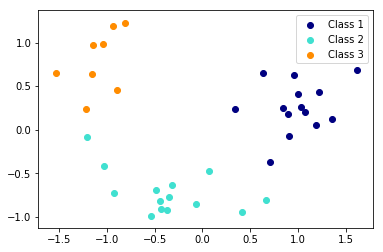

In [19]:
from sklearn.decomposition import PCA
import pandas as pd
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_test)
finalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])
finalDf['target'] = y_labels_test


colors = ['navy', 'turquoise', 'darkorange']
lw = 2
#plt.figure(figsize=(5,10))
#plt.subplot(211)

#plt.scatter(finalDf.loc[finalDf['target']==0,'pc1'], finalDf.loc[finalDf['target']==0,'pc2'], color=colors[0])
#plt.scatter(finalDf.loc[finalDf['target']==1,'pc1'], finalDf.loc[finalDf['target']==1,'pc2'], color=colors[1])
#plt.scatter(finalDf.loc[finalDf['target']==2,'pc1'], finalDf.loc[finalDf['target']==2,'pc2'], color=colors[2])

#plt.subplot(212)
plt.figure()
finalDf['target'] = y_pred_test
plt.scatter(finalDf.loc[finalDf['target']==0,'pc1'], finalDf.loc[finalDf['target']==0,'pc2'], color=colors[0], label='Class 1')
plt.scatter(finalDf.loc[finalDf['target']==1,'pc1'], finalDf.loc[finalDf['target']==1,'pc2'], color=colors[1], label='Class 2')
plt.scatter(finalDf.loc[finalDf['target']==2,'pc1'], finalDf.loc[finalDf['target']==2,'pc2'], color=colors[2], label='Class 3')
plt.legend()
plt.savefig('D:/wines.png')

plt.show()